
#  the model in this file comes from this website

#  https://geertlitjens.nl/post/getting-started-with-camelyon/



#  without editing the model, it is 80% accurate/confident

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

pcam, pcam_info = tfds.load('patch_camelyon', shuffle_files=True, with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteVVRWBJ/patch_camelyon-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteVVRWBJ/patch_camelyon-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteVVRWBJ/patch_camelyon-validation.tfrecord


Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [0]:
#print(pcam)

In [0]:
#model = tf.keras.models.load_model('./patchcamelyon.hf5')

In [4]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import TensorFlow and relevant Keras classes to setup the model
#import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [0]:
#First setup the input to the network which has the dimensions of the patches contained within PatchCAMELYON
input_img = Input(shape=(96,96,3))

# Now we define the layers of the convolutional network: three blocks of two convolutional layers and a max-pool layer.
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = BatchNormalization()(x)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

# Now we flatten the output from a 4D to a 2D tensor to be able to use fully-connected (dense) layers for the final
# classification part. Here we also use a bit of dropout for regularization. The last layer uses a softmax to obtain class
# likelihoods (i.e. metastasis vs. non-metastasis)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
model2 = Model(inputs=input_img, outputs=predictions)
#sgd_opt = SGD(lr=0.001, momentum=0.999, decay=0.0, nesterov=True)
model2.compile(optimizer=Adam(0.009), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
#model.summary()

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [8]:
hist2 = model2.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=10, steps_per_epoch=4096, validation_steps=256)

Epoch 1/10
4096/4096 - 171s - loss: 0.3610 - accuracy: 0.8461 - val_loss: 0.5325 - val_accuracy: 0.8033
Epoch 2/10
4096/4096 - 136s - loss: 0.2793 - accuracy: 0.8869 - val_loss: 2.5831 - val_accuracy: 0.6158
Epoch 3/10
4096/4096 - 144s - loss: 0.2435 - accuracy: 0.9040 - val_loss: 0.5166 - val_accuracy: 0.7765
Epoch 4/10
4096/4096 - 145s - loss: 0.2260 - accuracy: 0.9122 - val_loss: 0.8907 - val_accuracy: 0.7495
Epoch 5/10
4096/4096 - 161s - loss: 0.2121 - accuracy: 0.9193 - val_loss: 1.5421 - val_accuracy: 0.6802
Epoch 6/10
4096/4096 - 151s - loss: 0.2044 - accuracy: 0.9220 - val_loss: 0.4127 - val_accuracy: 0.8308
Epoch 7/10
4096/4096 - 145s - loss: 0.1970 - accuracy: 0.9252 - val_loss: 0.5968 - val_accuracy: 0.8057
Epoch 8/10
4096/4096 - 150s - loss: 0.1891 - accuracy: 0.9287 - val_loss: 0.6647 - val_accuracy: 0.7701
Epoch 9/10
4096/4096 - 166s - loss: 0.1851 - accuracy: 0.9308 - val_loss: 1.3317 - val_accuracy: 0.7198
Epoch 10/10
4096/4096 - 158s - loss: 0.1867 - accuracy: 0.9302 -

In [9]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model2.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8124


In [0]:
#model2.save("pcam2")

In [0]:
#model3 = tf.keras.models.load_model('pcam2')

In [0]:
#e3 = model3.evaluate(test_pipeline, steps=128, verbose=0)

In [0]:
#print(e3)

In [0]:
#print(test_pipeline)

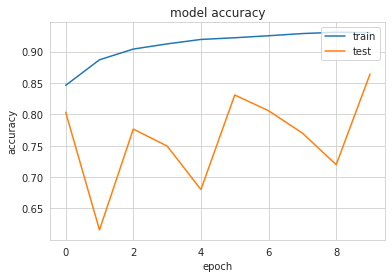

In [15]:
# summarize history for loss
plt.figure()
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

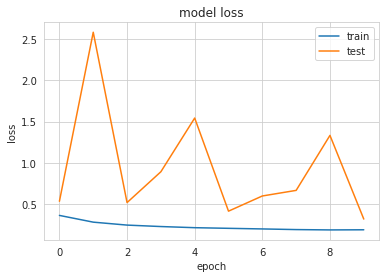

In [16]:
# summarize history for loss
plt.figure()
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [17]:

#Predict on test set
predictions_NN_prob = model2.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output



y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])

#Print accuracy
acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.505340576171875


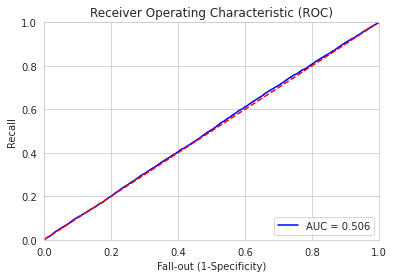

In [18]:
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

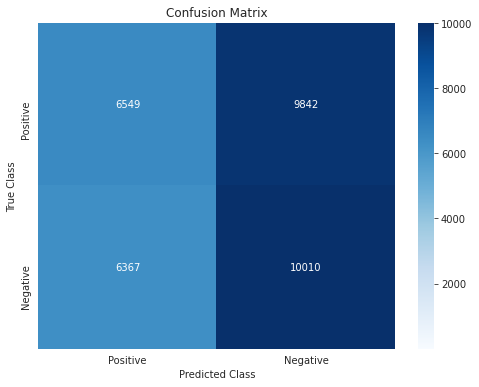

In [19]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Positive', 'Negative']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
model_5_16_2020 = Model(inputs=input_img, outputs=predictions)
#sgd_opt = SGD(lr=0.001, momentum=0.999, decay=0.0, nesterov=True)
model_5_16_2020.compile(optimizer= Adam(0.007), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [0]:
train_pipeline = pcam['train'].map(convert_sample, num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample, num_parallel_calls=8).repeat().batch(128).prefetch(2)


In [25]:
hist_5_16_2020 = model_5_16_2020.fit(train_pipeline, validation_data=valid_pipeline, verbose=2, epochs=10, steps_per_epoch=4096, validation_steps=256)

Epoch 1/10
4096/4096 - 181s - loss: 0.1720 - accuracy: 0.9359 - val_loss: 0.6418 - val_accuracy: 0.7890
Epoch 2/10
4096/4096 - 168s - loss: 0.1669 - accuracy: 0.9380 - val_loss: 0.4666 - val_accuracy: 0.8347
Epoch 3/10
4096/4096 - 135s - loss: 0.1620 - accuracy: 0.9402 - val_loss: 0.6024 - val_accuracy: 0.7945
Epoch 4/10
4096/4096 - 166s - loss: 0.1618 - accuracy: 0.9403 - val_loss: 0.7332 - val_accuracy: 0.7613
Epoch 5/10
4096/4096 - 163s - loss: 0.1598 - accuracy: 0.9409 - val_loss: 0.6317 - val_accuracy: 0.8175
Epoch 6/10
4096/4096 - 159s - loss: 0.1577 - accuracy: 0.9418 - val_loss: 1.1751 - val_accuracy: 0.7201
Epoch 7/10
4096/4096 - 198s - loss: 0.1563 - accuracy: 0.9429 - val_loss: 0.4306 - val_accuracy: 0.8442
Epoch 8/10
4096/4096 - 157s - loss: 0.1533 - accuracy: 0.9437 - val_loss: 0.5205 - val_accuracy: 0.8336
Epoch 9/10
4096/4096 - 176s - loss: 0.1524 - accuracy: 0.9437 - val_loss: 0.4668 - val_accuracy: 0.8313
Epoch 10/10
4096/4096 - 171s - loss: 0.1506 - accuracy: 0.9447 -

In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves


#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(128, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(64, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(32, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(16, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))


model.add(Dense(2, activation = "softmax"))

model.compile(optimizer=Adam(0.008), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
#model.summary()

In [0]:
# def convert_sample(sample):
#     image, label = sample['image'], sample['label']  
#     image = tf.image.convert_image_dtype(image, tf.float32)
#     #image = tf.image.rgb_to_grayscale(image)
#     label = tf.one_hot(label, 2, dtype=tf.float32)
#     return image, label

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)



In [29]:
hist = model.fit(train_pipeline, validation_data=valid_pipeline, verbose=2, epochs=10, steps_per_epoch=4096, validation_steps=256)


Epoch 1/10
4096/4096 - 150s - loss: 0.3494 - accuracy: 0.8547 - val_loss: 0.4304 - val_accuracy: 0.8227
Epoch 2/10
4096/4096 - 157s - loss: 0.2444 - accuracy: 0.9058 - val_loss: 0.7565 - val_accuracy: 0.7436
Epoch 3/10
4096/4096 - 152s - loss: 0.2113 - accuracy: 0.9203 - val_loss: 0.8496 - val_accuracy: 0.7560
Epoch 4/10
4096/4096 - 155s - loss: 0.1933 - accuracy: 0.9289 - val_loss: 0.9646 - val_accuracy: 0.7358
Epoch 5/10
4096/4096 - 150s - loss: 0.1809 - accuracy: 0.9339 - val_loss: 0.9061 - val_accuracy: 0.7737
Epoch 6/10
4096/4096 - 153s - loss: 0.1710 - accuracy: 0.9381 - val_loss: 0.3178 - val_accuracy: 0.8639
Epoch 7/10
4096/4096 - 148s - loss: 0.1628 - accuracy: 0.9412 - val_loss: 0.7899 - val_accuracy: 0.7422
Epoch 8/10
4096/4096 - 153s - loss: 0.1547 - accuracy: 0.9444 - val_loss: 0.4060 - val_accuracy: 0.8427
Epoch 9/10
4096/4096 - 147s - loss: 0.1492 - accuracy: 0.9469 - val_loss: 0.4475 - val_accuracy: 0.8465
Epoch 10/10
4096/4096 - 150s - loss: 0.1455 - accuracy: 0.9483 -

In [30]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8021


In [0]:
#model.save("pcam")

In [0]:
# #Import modules
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers import Activation, Dense, Dropout
# from keras import optimizers
# from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
# %matplotlib inline
# sns.set_style("whitegrid")
# np.random.seed(697)

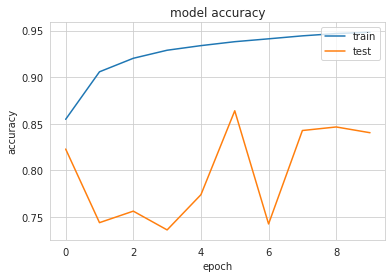

In [33]:
# summarize history for loss
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

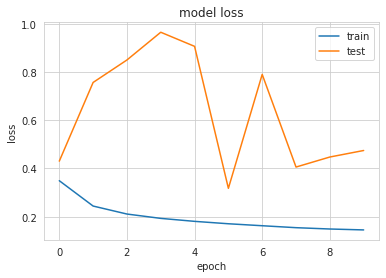

In [34]:
# summarize history for loss
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
# test_x = []
# test_y = []
# for i in pcam['test']:
#   x,y = convert_sample(i)
#   test_x.append(x)
#   test_y.append(y)

In [36]:
y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])

#Predict on test set
predictions_NN_prob = model.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

#Print accuracy
acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.500640869140625


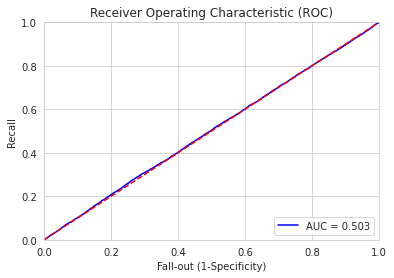

In [37]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

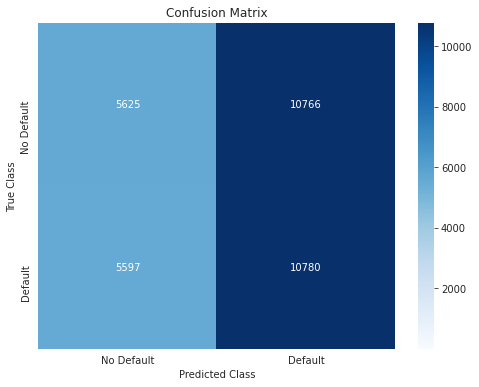

In [38]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves


#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model_z = Sequential()


#conv block 1
model_z.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model_z.add(BatchNormalization())
model_z.add(Activation("relu"))
model_z.add(Conv2D(first_filters, kernel_size, use_bias=False))
model_z.add(BatchNormalization())
model_z.add(Activation("relu"))
model_z.add(MaxPool2D(pool_size = pool_size)) 
model_z.add(Dropout(dropout_conv))

#conv block 2
model_z.add(Conv2D(second_filters, kernel_size, use_bias=False))
model_z.add(BatchNormalization())
model_z.add(Activation("relu"))
model_z.add(Conv2D(second_filters, kernel_size, use_bias=False))
model_z.add(BatchNormalization())
model_z.add(Activation("relu"))
model_z.add(MaxPool2D(pool_size = pool_size))
model_z.add(Dropout(dropout_conv))

#conv block 3
model_z.add(Conv2D(third_filters, kernel_size, use_bias=False))
model_z.add(BatchNormalization())
model_z.add(Activation("relu"))
model_z.add(Conv2D(third_filters, kernel_size, use_bias=False))
model_z.add(BatchNormalization())
model_z.add(Activation("relu"))
model_z.add(MaxPool2D(pool_size = pool_size))
model_z.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model_z.add(Flatten())
model_z.add(Dense(256, use_bias=False))
model_z.add(BatchNormalization())
model_z.add(Activation("relu"))
model_z.add(Dropout(dropout_dense))
model_z.add(Dense(128, use_bias=False))
model_z.add(BatchNormalization())
model_z.add(Activation("relu"))
model.add(Dropout(dropout_dense))

model_z.add(Dense(2, activation = "softmax"))
sgd_opt = SGD(lr=0.007, momentum=0.1, decay=0.0, nesterov=True)
model_z.compile(optimizer=sgd_opt, loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
#model.summary()

In [41]:
hist_z = model_z.fit(train_pipeline, validation_data=valid_pipeline, verbose=2, epochs=10, steps_per_epoch=4096, validation_steps=256)

Epoch 1/10
4096/4096 - 171s - loss: 0.4158 - accuracy: 0.8164 - val_loss: 0.4392 - val_accuracy: 0.8014
Epoch 2/10
4096/4096 - 142s - loss: 0.3555 - accuracy: 0.8476 - val_loss: 0.5680 - val_accuracy: 0.7653
Epoch 3/10
4096/4096 - 140s - loss: 0.3245 - accuracy: 0.8628 - val_loss: 0.5851 - val_accuracy: 0.7594
Epoch 4/10
4096/4096 - 143s - loss: 0.3015 - accuracy: 0.8740 - val_loss: 0.5166 - val_accuracy: 0.8062
Epoch 5/10
4096/4096 - 139s - loss: 0.2799 - accuracy: 0.8850 - val_loss: 0.5958 - val_accuracy: 0.7989
Epoch 6/10
4096/4096 - 140s - loss: 0.2658 - accuracy: 0.8916 - val_loss: 0.4711 - val_accuracy: 0.8219
Epoch 7/10
4096/4096 - 142s - loss: 0.2520 - accuracy: 0.8983 - val_loss: 0.3983 - val_accuracy: 0.8462
Epoch 8/10
4096/4096 - 141s - loss: 0.2416 - accuracy: 0.9035 - val_loss: 0.4356 - val_accuracy: 0.8495
Epoch 9/10
4096/4096 - 139s - loss: 0.2329 - accuracy: 0.9072 - val_loss: 0.3572 - val_accuracy: 0.8619
Epoch 10/10
4096/4096 - 142s - loss: 0.2263 - accuracy: 0.9109 -

In [42]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model_z.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8427


In [46]:
model_z.save('pcam_model_z')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: pcam_model_z/assets


INFO:tensorflow:Assets written to: pcam_model_z/assets


In [0]:
'''
#First setup the input to the network which has the dimensions of the patches contained within PatchCAMELYON
input_img = Input(shape=(96,96,3))

# Now we define the layers of the convolutional network: three blocks of two convolutional layers and a max-pool layer.
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Now we flatten the output from a 4D to a 2D tensor to be able to use fully-connected (dense) layers for the final
# classification part. Here we also use a bit of dropout for regularization. The last layer uses a softmax to obtain class
# likelihoods (i.e. metastasis vs. non-metastasis)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
predictions = Dense(2, activation='softmax')(x)
'''
# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
#model3 = Model(inputs=input_img, outputs=predictions)
sgd_opt = SGD(lr=0.008, momentum=0.2, decay=0.0, nesterov=True)
model_z.compile(optimizer=sgd_opt, loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
#model.summary()

In [0]:
train_pipeline = pcam['train'].map(convert_sample, num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample, num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [49]:
hist_z2 = model_z.fit(train_pipeline, validation_data=valid_pipeline, verbose=2, epochs=20, steps_per_epoch=4096, validation_steps=256)

Epoch 1/20
4096/4096 - 170s - loss: 0.2224 - accuracy: 0.9117 - val_loss: 0.4652 - val_accuracy: 0.8308
Epoch 2/20
4096/4096 - 138s - loss: 0.2140 - accuracy: 0.9160 - val_loss: 0.4323 - val_accuracy: 0.8448
Epoch 3/20
4096/4096 - 140s - loss: 0.2074 - accuracy: 0.9190 - val_loss: 0.3534 - val_accuracy: 0.8626
Epoch 4/20
4096/4096 - 144s - loss: 0.2024 - accuracy: 0.9218 - val_loss: 0.4024 - val_accuracy: 0.8496
Epoch 5/20
4096/4096 - 142s - loss: 0.1958 - accuracy: 0.9242 - val_loss: 0.5785 - val_accuracy: 0.8087
Epoch 6/20
4096/4096 - 141s - loss: 0.1917 - accuracy: 0.9262 - val_loss: 0.3204 - val_accuracy: 0.8753
Epoch 7/20
4096/4096 - 143s - loss: 0.1874 - accuracy: 0.9278 - val_loss: 0.3135 - val_accuracy: 0.8792
Epoch 8/20
4096/4096 - 140s - loss: 0.1834 - accuracy: 0.9296 - val_loss: 0.3952 - val_accuracy: 0.8588
Epoch 9/20
4096/4096 - 141s - loss: 0.1789 - accuracy: 0.9315 - val_loss: 0.3713 - val_accuracy: 0.8667
Epoch 10/20
4096/4096 - 144s - loss: 0.1747 - accuracy: 0.9332 -

In [50]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model_z.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.7876


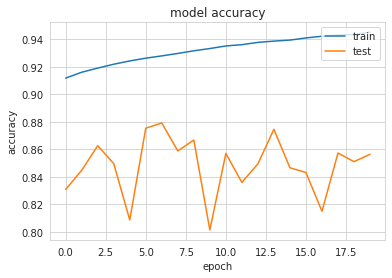

In [53]:
# summarize history for loss
plt.figure()
plt.plot(hist_z2.history['accuracy'])
plt.plot(hist_z2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

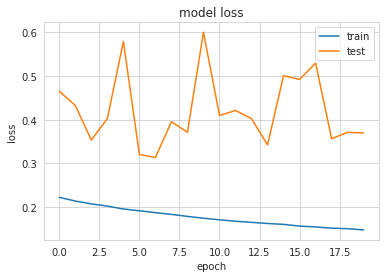

In [54]:
# summarize history for loss
plt.figure()
plt.plot(hist_z2.history['loss'])
plt.plot(hist_z2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [57]:
model4 = Model(inputs=input_img, outputs=predictions)
sgd_opt = SGD(lr=0.008, momentum=0.5, decay=0.0, nesterov=True)
model4.compile(optimizer=sgd_opt, loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

train_pipeline = pcam['train'].map(convert_sample, num_parallel_calls=8).shuffle(1024).repeat().batch(128).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample, num_parallel_calls=8).repeat().batch(128).prefetch(2)

hist4 = model4.fit(train_pipeline, validation_data=valid_pipeline, verbose=2, epochs=20, steps_per_epoch=2048, validation_steps=256)

test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model4.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Epoch 1/20
2048/2048 - 170s - loss: 0.1245 - accuracy: 0.9541 - val_loss: 0.5315 - val_accuracy: 0.8314
Epoch 2/20
2048/2048 - 114s - loss: 0.1238 - accuracy: 0.9543 - val_loss: 0.5307 - val_accuracy: 0.8328
Epoch 3/20
2048/2048 - 136s - loss: 0.1232 - accuracy: 0.9549 - val_loss: 0.5484 - val_accuracy: 0.8288
Epoch 4/20
2048/2048 - 122s - loss: 0.1236 - accuracy: 0.9544 - val_loss: 0.5276 - val_accuracy: 0.8325
Epoch 5/20
2048/2048 - 147s - loss: 0.1234 - accuracy: 0.9546 - val_loss: 0.5458 - val_accuracy: 0.8301
Epoch 6/20
2048/2048 - 106s - loss: 0.1243 - accuracy: 0.9542 - val_loss: 0.5496 - val_accuracy: 0.8290
Epoch 7/20
2048/2048 - 133s - loss: 0.1238 - accuracy: 0.9546 - val_loss: 0.5347 - val_accuracy: 0.8305
Epoch 8/20
2048/2048 - 131s - loss: 0.1240 - accuracy: 0.9547 - val_loss: 0.5385 - val_accuracy: 0.8305
Epoch 9/20
2048/2048 - 130s - loss: 0.1237 - accuracy: 0.9549 - val_loss: 0.5322 - val_accuracy: 0.8316
Epoch 10/20
2048/2048 - 138s - loss: 0.1249 - accuracy: 0.9543 -

KeyboardInterrupt: ignored

In [58]:
# summarize history for loss
plt.figure()
plt.plot(hist4.history['accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
# summarize history for loss
plt.figure()
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
sgd_opt = SGD(lr=0.007, momentum=0.5, decay=0.0, nesterov=True)
model_z_y_momentum.compile(optimizer=sgd_opt, loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

model_z_y_momentum = model_z.fit(train_pipeline, validation_data=valid_pipeline, verbose=2, epochs=20, steps_per_epoch=4096, validation_steps=256)

In [0]:

#First setup the input to the network which has the dimensions of the patches contained within PatchCAMELYON
input_img = Input(shape=(96,96,3))

# Now we define the layers of the convolutional network: three blocks of two convolutional layers and a max-pool layer.
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

# 
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

#
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

# Now we flatten the output from a 4D to a 2D tensor to be able to use fully-connected (dense) layers for the final
# classification part. Here we also use a bit of dropout for regularization. The last layer uses a softmax to obtain class
# likelihoods (i.e. metastasis vs. non-metastasis)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate=0.1)(x)
predictions = Dense(2, activation='softmax')(x)

# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
model_A = Model(inputs=input_img, outputs=predictions)
#sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
model_A.compile(optimizer=Adam(0.0001),
              loss=tf.keras.losses.binary_crossentropy,#'binary_crossentropy',
              metrics=['accuracy'])
#model.summary()

In [0]:
train_pipeline = pcam['train'].map(convert_sample, num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample, num_parallel_calls=8).repeat().batch(128).prefetch(2)

hist_A = model_A.fit(train_pipeline, validation_data=valid_pipeline, verbose=2, epochs=20, steps_per_epoch=4096, validation_steps=256)

test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model_A.evaluate(test_pipeline, steps=128, verbose=0)[1]))

In [0]:
'''
#First setup the input to the network which has the dimensions of the patches contained within PatchCAMELYON
input_img = Input(shape=(96,96,3))

# Now we define the layers of the convolutional network: three blocks of two convolutional layers and a max-pool layer.
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

# 
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

#
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

# Now we flatten the output from a 4D to a 2D tensor to be able to use fully-connected (dense) layers for the final
# classification part. Here we also use a bit of dropout for regularization. The last layer uses a softmax to obtain class
# likelihoods (i.e. metastasis vs. non-metastasis)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate=0.1)(x)
predictions = Dense(2, activation='softmax')(x)
'''
# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
model_B = Model(inputs=input_img, outputs=predictions)
sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
model_B.compile(optimizer=sgd_opt,
              loss=tf.keras.losses.binary_crossentropy,#'binary_crossentropy',
              metrics=['accuracy'])
#model.summary()

In [0]:
train_pipeline = pcam['train'].map(convert_sample, num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample, num_parallel_calls=8).repeat().batch(128).prefetch(2)

hist_B = model_B.fit(train_pipeline, validation_data=valid_pipeline, verbose=2, epochs=20, steps_per_epoch=4096, validation_steps=2048)

test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model_B.evaluate(test_pipeline, steps=256, verbose=0)[1]))